In [1]:
## Centerized Matplot Figure
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [23]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import Heart_Disease_Function as hf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [3]:
## Load the Data
df = pd.read_csv("data/heart disease.csv")

## Modeling

In [4]:
## Split data into X and y
X = df.drop("target", axis = 1)
y = df["target"]
## Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

Now we have splitted our data into train and test sets, We will construct our machine learning model by training it (find the patterns) on the training set and test (use the pattern) on the test set.

We are going to try three different machine learning models: 
> 1. Logistic Regression
> 2. K-Nearest Neighbors Classifiers
> 3. Random Forest Classifier

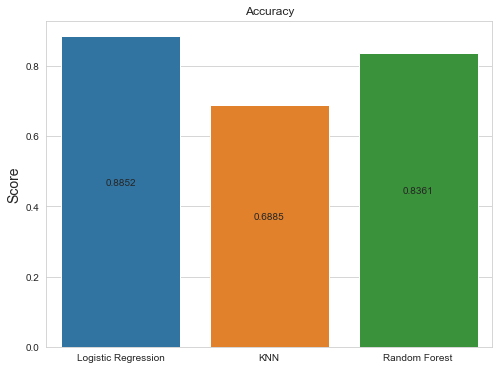

In [5]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=10000),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(n_estimators = 100)}
# Score the model
models_scores = hf.fit_and_score(models, X_train, X_test, y_train, y_test)
# Create a dataFrame for models score
models_scores_dataframe = pd.DataFrame(models_scores, index = [0])
# Model Score Comparison
hf.model_comparison_score(models_scores_dataframe, "Score", "Accuracy")

Now we have got a baseline model ... and we know a model's first prediction are not always what we should based our next steps off. What should we do? 

Let's look at the following: 

* Hyperparameter tuning
* Feature importance
* Confusion Matrix
* Cross-validation
* Precision
* Recall
* Classification report
* ROC curve
* Area under the curve (AUC)

### Hyperparameter tuning

Maximum KNN score on the test data :  75.41%


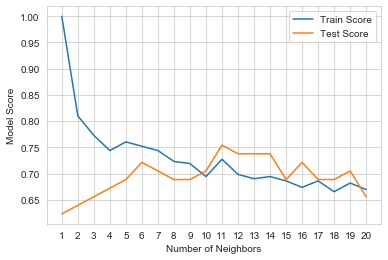

In [6]:
#Let's Tune KNN model
hf.knn_tuning(1,21, X_train, y_train, X_test, y_test, "Number of Neighbors", "Model Score")

## Hyperparameter tuning with RandomizedSearchV

We are going to tune:
* LogisticRegression()
* RandomForestClassifier()

... using RandomizedSearchCV

In [7]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C" : np.logspace(-4,4,20),
                "solver": ["liblinear"]}
# Tune LogisticRegression and Setup random hyperparameter search for Logistic Regression
rs_log_reg_grid = RandomizedSearchCV(estimator = LogisticRegression(), param_distributions=log_reg_grid,
                                     cv = 5, n_iter=20,verbose=True, random_state=42)
# Fit random hyperparameter search model for LogisticRegression
rs_log_reg_grid.fit(X_train, y_train)
# Find the best hyperparameters
print(f'Best Hyperparameters: {rs_log_reg_grid.best_params_}')
# Evaluate the Randomized Search for LogisticRegression model
rs_log_reg_grid.score(X_test, y_test)
print(f'The score from Logistic Regression RandomizedSearchCV tuning: {rs_log_reg_grid.score(X_test, y_test)}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Hyperparameters: {'solver': 'liblinear', 'C': 0.23357214690901212}
The score from Logistic Regression RandomizedSearchCV tuning: 0.8852459016393442


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


## Lets now tune RandomForestClassifier()...


In [8]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50), "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2), "min_samples_leaf": np.arange(1,20,2)}
# Tune RandomForestClassifier andSetup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions=rf_grid, cv = 5,n_iter=20,
                                     verbose=True, random_state=42)
# Fit random hyperparameter search model for RandomForestClassifier
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   random_state=42, verbose=True)

In [9]:
# Find the best hyperparameters
print(f'Best Hyperparameters: {rs_rf.best_params_}' )
# Evaluate the Randomized Search RandomForestClassifier 
print(f'The score from RandomForest RandomizedSearchCV tuning: {rs_rf.score(X_test, y_test)}')

Best Hyperparameters: {'n_estimators': 310, 'min_samples_split': 2, 'min_samples_leaf': 19, 'max_depth': 5}
The score from RandomForest RandomizedSearchCV tuning: 0.8688524590163934


## Hyperparameter Tunig with GridSearchCV

Since our LogisticRegression model provides the best scores so far, we will try and improve them again using GridSearchCV...

In [10]:
## Different hyperparameter for our LogisticRegression model
log_reg_grid = {"C" : np.logspace(-4,4,100),
                "solver": ["liblinear"]}

# Setup random hyperparameter search for Logistic Regression
gs_log_reg_grid = GridSearchCV(LogisticRegression(),
                               param_grid=log_reg_grid,
                               cv = 5,
                               verbose=True)

# Fit grid hyperparameter search model
gs_log_reg_grid.fit(X_train, y_train)

# Check the best hypeerparameters
print(gs_log_reg_grid.best_params_)

# Evaluate the Randomized Search Logistic Regression
gs_log_reg_grid.score(X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 0.20565123083486536, 'solver': 'liblinear'}


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.5s finished


0.8852459016393442

## Evaluating our tuned machine learning classifier, beyond accuracy
* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F-1 score

... and use cross-validation where possible

To make comparison and evaluate our trained model, first we make predictions.


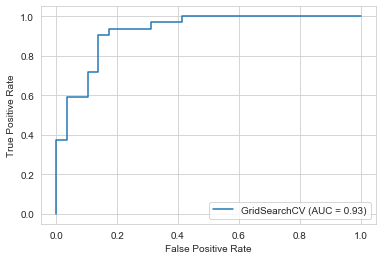

In [12]:
# Make prediction with tuned model
y_pred = gs_log_reg_grid.predict(X_test)
# Plot ROC curve and calculate AUC metric
plot_roc_curve(gs_log_reg_grid, X_test, y_test);

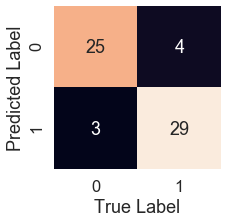

In [13]:
# Visualization of Confusion Matrix
hf.plot_conf_mat(y_test, y_pred)

We see that the model gets confused so predicts the wrong label relatively the same across both classes. In essence, there are four occassions where the model predicted 0 when someone do not have heart disease when they should have been predicted as 1. This is called `False negative` (model predicts 0 when truth is 1). Furthermore, we have 3 instances where the mdoel predicts 1 (someone does have heart disease) when they actually don't. This is called `False positives` (model predict 1 when truth is 0)


   Note: In reality we want to avoid both `False negative` and `False positives` especially when working with severe heart disease problem. We do not want to predict heart disease of a patient when it is not present or vice versa. Therefore, when building a model we want to consider wether False negative is worse or False positives is worse. A perfect model would have none of these but in reality we recive some sort of this types.
   
   
 ## Classification Report 

In [14]:
print(classification_report(y_test, y_pred, target_names = ['No Disease 0', 'Heart Disease 1']))

                 precision    recall  f1-score   support

   No Disease 0       0.89      0.86      0.88        29
Heart Disease 1       0.88      0.91      0.89        32

       accuracy                           0.89        61
      macro avg       0.89      0.88      0.88        61
   weighted avg       0.89      0.89      0.89        61



## Calculate Evaluation metric using cross-validation

In [15]:
# Check best hyperparmeter
gs_log_reg_grid.best_params_

{'C': 0.20565123083486536, 'solver': 'liblinear'}

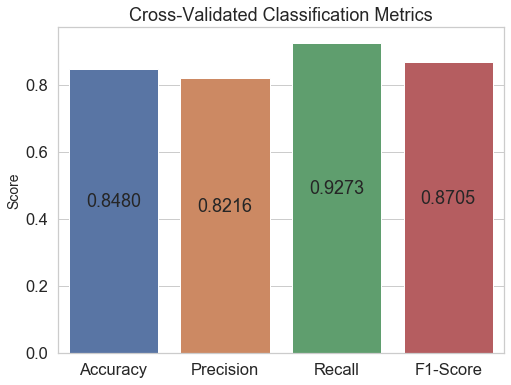

In [16]:
# Create a new classifier with best parameters
clf = LogisticRegression(C= 0.20565123083486536, 
                         solver ='liblinear')
# Cross-validated accuracy
cv_acc = cross_val_score(clf, X, y, cv=5, scoring = "accuracy")
cv_acc = np.mean(cv_acc)
# Cross-validated precision
cv_precision = cross_val_score(clf, X, y, cv=5, scoring = "precision")
cv_precision = np.mean(cv_precision)
# Cross-validated f1
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring = "f1")
cv_f1 = np.mean(cv_f1)
# Cross-validated recall
cv_recall = cross_val_score(clf, X, y, cv=5, scoring="recall")
cv_recall = np.mean(cv_recall)
# Cross Validated Classification Metrics DataFrame
cv_metric_df = pd.DataFrame({"Accuracy": cv_acc,
                             "Precision": cv_precision,
                             "Recall": cv_recall,
                             "F1-Score": cv_f1},
                         index = [0])
# Visualize cross-validated matrix
hf.model_comparison_score(cv_metric_df, "Score", "Cross-Validated Classification Metrics")

### Feature Importance 
    Which feature contributed most to the outcomes of the model and how did they contribute?


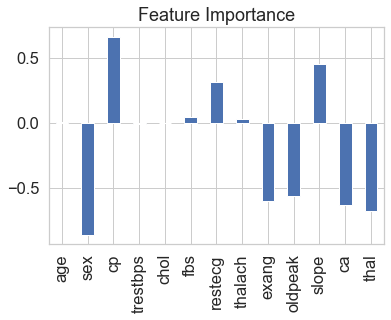

In [20]:
# Fit an instance of Logistic Regression 
clf = LogisticRegression(C = 0.20565123083486536, solver = "liblinear")
clf.fit(X_train, y_train);
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);

## Explore

We can see that sex is fairly negatively correlated as it is almost at the bottom. It means that when the value for the sex increases the target value decreases beacuse of the negative coefficent. 

In [21]:
pd.crosstab(df["sex"], df["target"])

target,0,1
sex,,
0,24,72
1,114,93


However, it does not makes sense based on the crosstab result. After looking at this, we see that the ratio is what we were thinking about. So as sex goes up, the target value ratio decreases. For example, if the sex is zero for female there is almost three to one ratio. And then as sex increases, the target goes down to about a 1 to 2  ratio. It's a negative correlation which means that sex is a negative coefficent. 


Now let's look at a positive coefficent --- Slope

We see that as slope increases the target should also increase as well because it is a positive coefficient

In [22]:
pd.crosstab(df["slope"], df["target"])

target,0,1
slope,,
0,12,9
1,91,49
2,35,107


There are three values for slope 0, 1 and 2. So as it increases, the number of samples in the target columns also increases
## Conclussion
The goal was to obtain 95% accuracy report but we hitted almost 88.5%. If we want to improve the evalution metric in future we can come back to this project and do the following:

    * Collect more data if possible
    * Try a better scikit learn model. For example CatBoost or XGBoost
    
But this far, we will accept our models and finish this off for now. 